Packages

In [1]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [2]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5[var].isel(time=idx, latitude=lat_idx, longitude=lon_idx).data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values # dew point temperature in celsius

    # Extract air temperature (T) values from the input dataset, and convert to celsius
    T = era5_ds.t2m.values # temperature in celsius
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

Load datasets

In [3]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')
ERA5big=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5big.nc')
ostia_regrid=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ostia_regrid.nc')

#coloc3msk
variables=['P_SEA', 'WIND_CORR10', 'u10', 'v10','dwlw', 'dwsw', 'sst', 't2m' , 'rh', 'skt']
coloc3msk=[] 
for i in np.arange(len(variables)):
    msk=np.isfinite(dsadcpH[variables[i]])
    coloc3msk.append(colocate_era5_sd(dsadcpH.sel(time=msk), ERA5big , variables[i]))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:02<00:00, 815.60it/s]


OSTIA-ERA5 investigation datasets

In [4]:
colocOSTIA=colocate_era5_sd(dsadcpH, ostia, 'sst')-273.15
colocOSTIA_regrid=colocate_era5_sd(dsadcpH, ostia_regrid, 'sst')-273.15
#colocOSTIAmsk=colocate_era5_sd(dsadcpH.sel(time=np.isfinite(dsadcpH.sst)), ostia, 'sst')-273.15
#distOSTIA=dist_era5_sd(dsadcpH, ostia)
colocOSTIA_analysis_error=colocate_era5_sd(dsadcpH.rename({'trajectory':'analysis_error'}), ostia, 'analysis_error')
colocOSTIA_regrid_analysis_error=colocate_era5_sd(dsadcpH.rename({'trajectory':'analysis_error'}), ostia_regrid, 'analysis_error')
#Create datasets to check ostia sst and analysis_error

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:02<00:00, 809.74it/s]


# Plot of input variables 

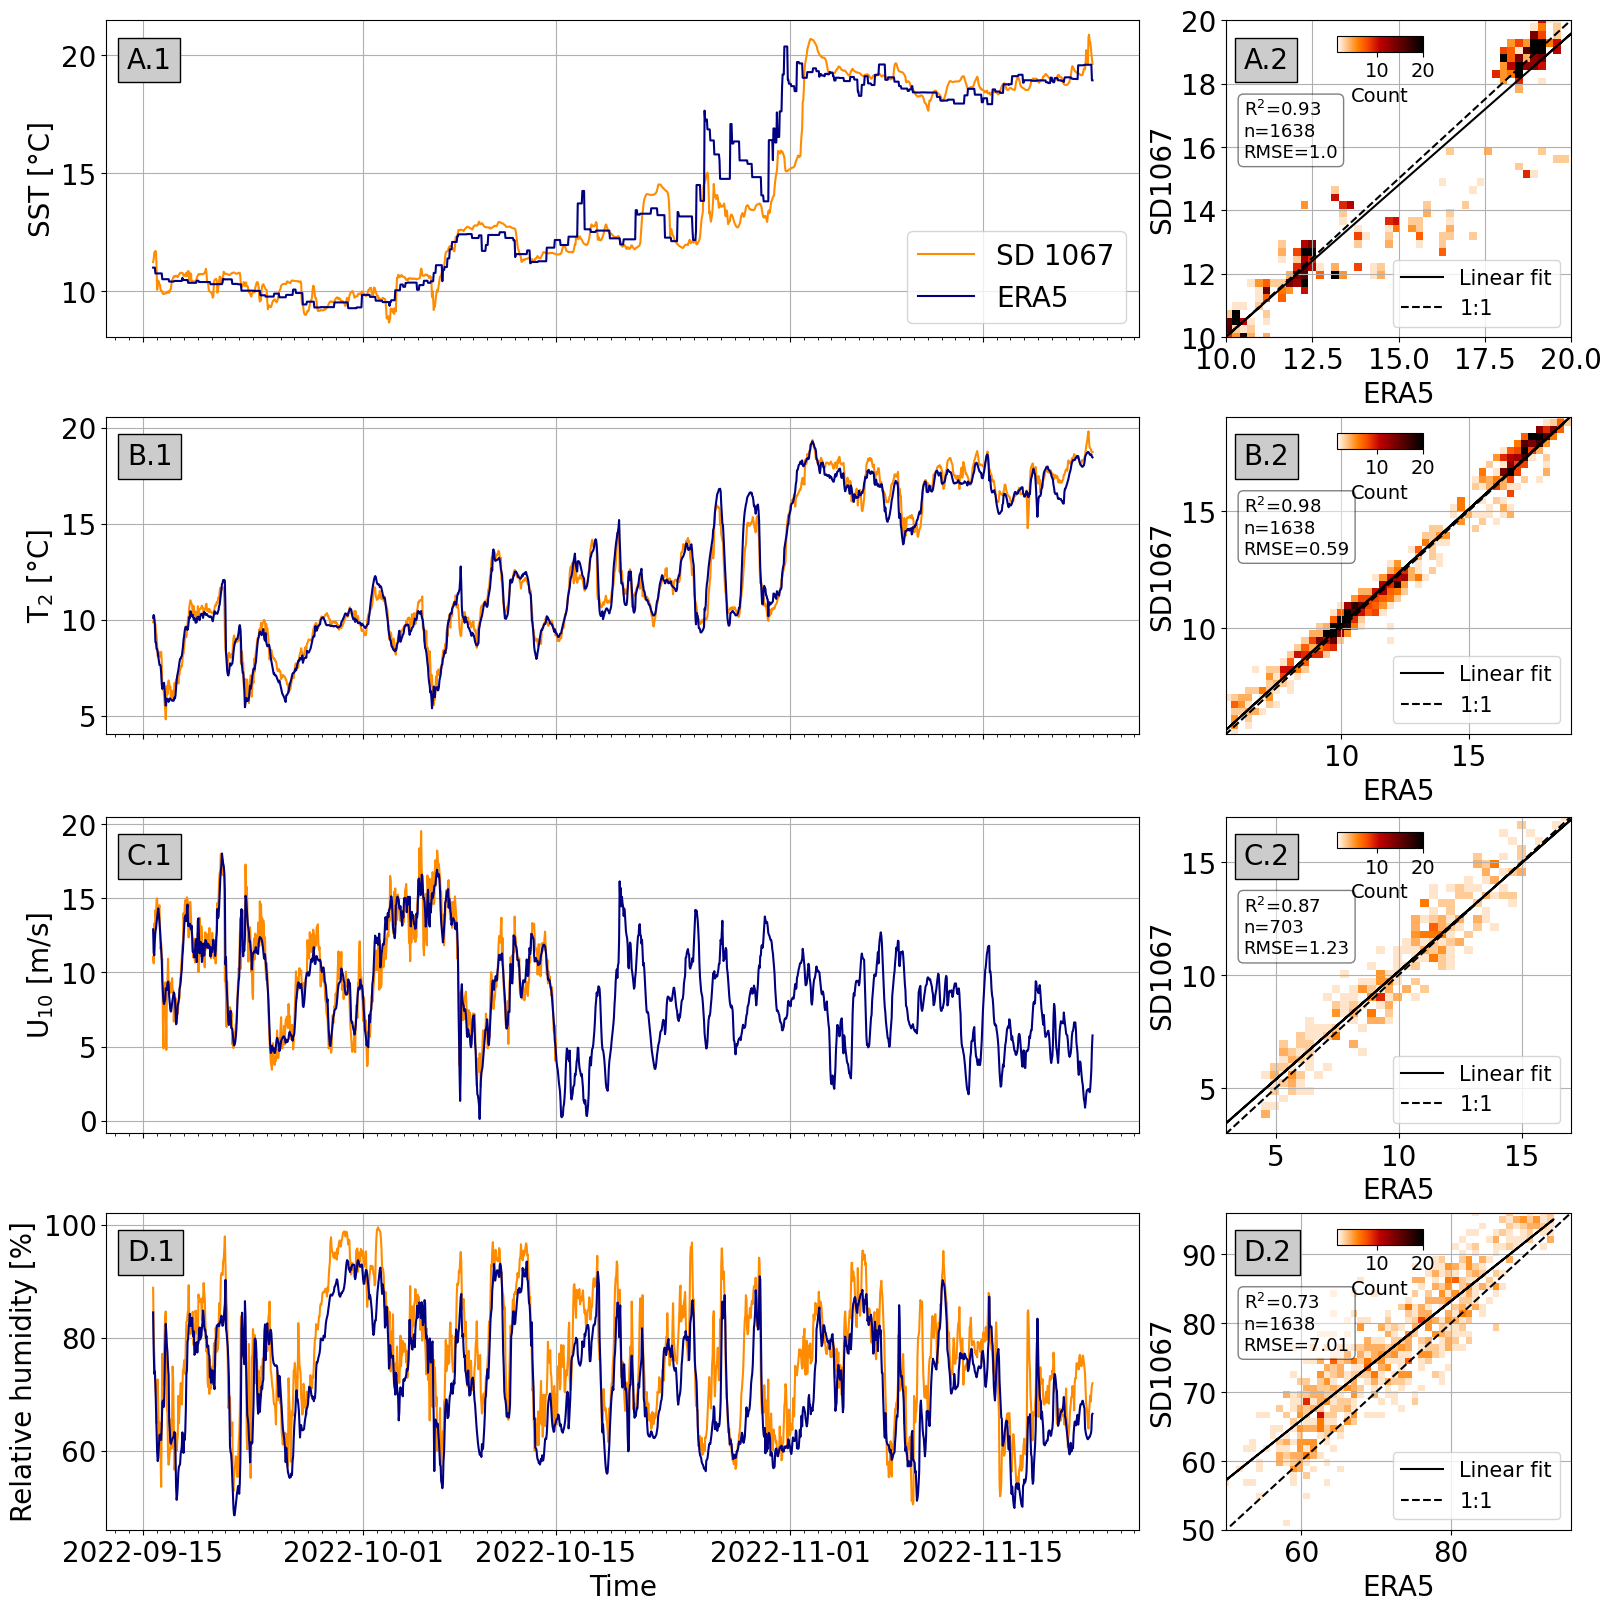

In [10]:
#variables=['P_SEA', 'WIND_CORR10', 'u10', 'v10','dwlw', 'dwsw', 'sst', 't2m' , 'rh', 'skt']

fig, ax = plt.subplot_mosaic([['a','a','a' ,'b'], ['c','c','c', 'd'], ['e','e','e' ,'f'], ['g','g','g', 'h']], figsize=[16,16], layout='constrained')
tims=['a','c','e', 'g']
corr=['b', 'd', 'f', 'h']
var=['sst', 't2m', 'WIND_CORR10', 'rh']
colocno=[6, 7, 1, 8] #sst, t2m, wind_corr10, rh
textstr=[]
lin=[]

ticksize=14

vmin=1
vmax=20

for i in np.arange(len(var)):
    ax[tims[i]].plot(dsadcpH.time, dsadcpH[var[i]], label='SD 1067', color='darkorange')
    ax[tims[i]].plot(dsadcpH.time, coloc3[var[i]], label='ERA5', color='navy')
    
    scat=ax[corr[i]].hist2d(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]])), bins=50,cmin=1, cmax=60,vmin=vmin, vmax=vmax, cmap='gist_heat_r')

    cax = ax[corr[i]].inset_axes([0.32, 0.9, 0.25, 0.05])
    cbar=fig.colorbar(scat[3], cax=cax, label=('Count'), orientation='horizontal')
    
    cbar.ax.tick_params(labelsize=ticksize)
    
    cbar.set_label(label='Count', size=ticksize)
    
    #Create linear fit line and plot
    y=dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))
    x=coloc3msk[colocno[i]]
 
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    ax[corr[i]].plot(x, m*x+b, color='k', label='Linear fit')
    
    #Create stats and statbox
    y_actual = coloc3msk[colocno[i]] 
    y_predicted =dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))
    RMSE = math.sqrt(mean_squared_error(y_actual, y_predicted))
    
    
    r2=scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).rvalue**2
    n = len(coloc3msk[colocno[i]])
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr.append( 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) )
                              
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#    ax[corr[i]].set_aspect('equal', adjustable="datalim")
    
    # place a text box in upper left in axes coords
    ax[corr[i]].annotate(textstr[i], xy=(0.05, 0.75), xycoords='axes fraction', bbox=props, va='top',fontsize=13)
    
    
    ax[corr[i]].set_xlabel('ERA5')
    ax[corr[i]].set_ylabel('SD1067')
    
      #ad grid, legend, 1:1 line
    #loc='upper left')
    ax[tims[i]].xaxis.set_minor_locator(mdates.DayLocator())
    ax[tims[i]].grid()
    ax[corr[i]].grid()
    ax[corr[i]].plot(np.arange(dsadcpH[var[i]].min(), dsadcpH[var[i]].max(), 1), np.arange(dsadcpH[var[i]].min(), dsadcpH[var[i]].max(), 1) , linestyle='--', color='k', label=('1:1'))
    ax[corr[i]].legend(loc='lower right', fontsize=15 )
    
ax['a'].set_ylabel('SST [°C]')   
ax['c'].set_ylabel('T$_2$ [°C]')   
ax['e'].set_ylabel('U$_{10}$ [m/s]')      
ax['g'].set_ylabel('Relative humidity [%]') 

ax['a'].legend(loc='lower right')

    #coloc3: PSEA, WIND_CORR10, u10, v10, dwlw, dwsw, sst, t2m, rh
    
_ = [ax[i].sharex(ax['a']) for i in 'ceg']    
_ = [ax[i].tick_params(labelbottom=False) for i in "ace"]    

#bdfh

ax['b'].set_xlim(10,20)
ax['b'].set_ylim(10,20)

ax['d'].set_xlim(5.5,19)
ax['d'].set_ylim(5.5,19)

ax['f'].set_xlim(3,17)
ax['f'].set_ylim(3,17)

ax['h'].set_xlim(50,96)
ax['h'].set_ylim(50,96)


bbox = dict(boxstyle="square", fc="0.8")

x=0.02
y=0.85

ax['a'].annotate('A.1', xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax['c'].annotate('B.1', xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax['e'].annotate('C.1', xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax['g'].annotate('D.1', xy=(x,y), xycoords='axes fraction', bbox=bbox)



x=0.05
y=0.85
ax['b'].annotate('A.2', xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax['d'].annotate('B.2', xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax['f'].annotate('C.2', xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax['h'].annotate('D.2', xy=(x,y), xycoords='axes fraction', bbox=bbox)


ax['g'].set_xlabel('Time')
    
plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/SD-ERA5-params.png')

## Important note on above figure, the displayed sst is BULK for both SD and ERA5. When fluxes are computed, skin temperature are used for the ERA5 data

Text(0, 0.5, 'SST [°C]')

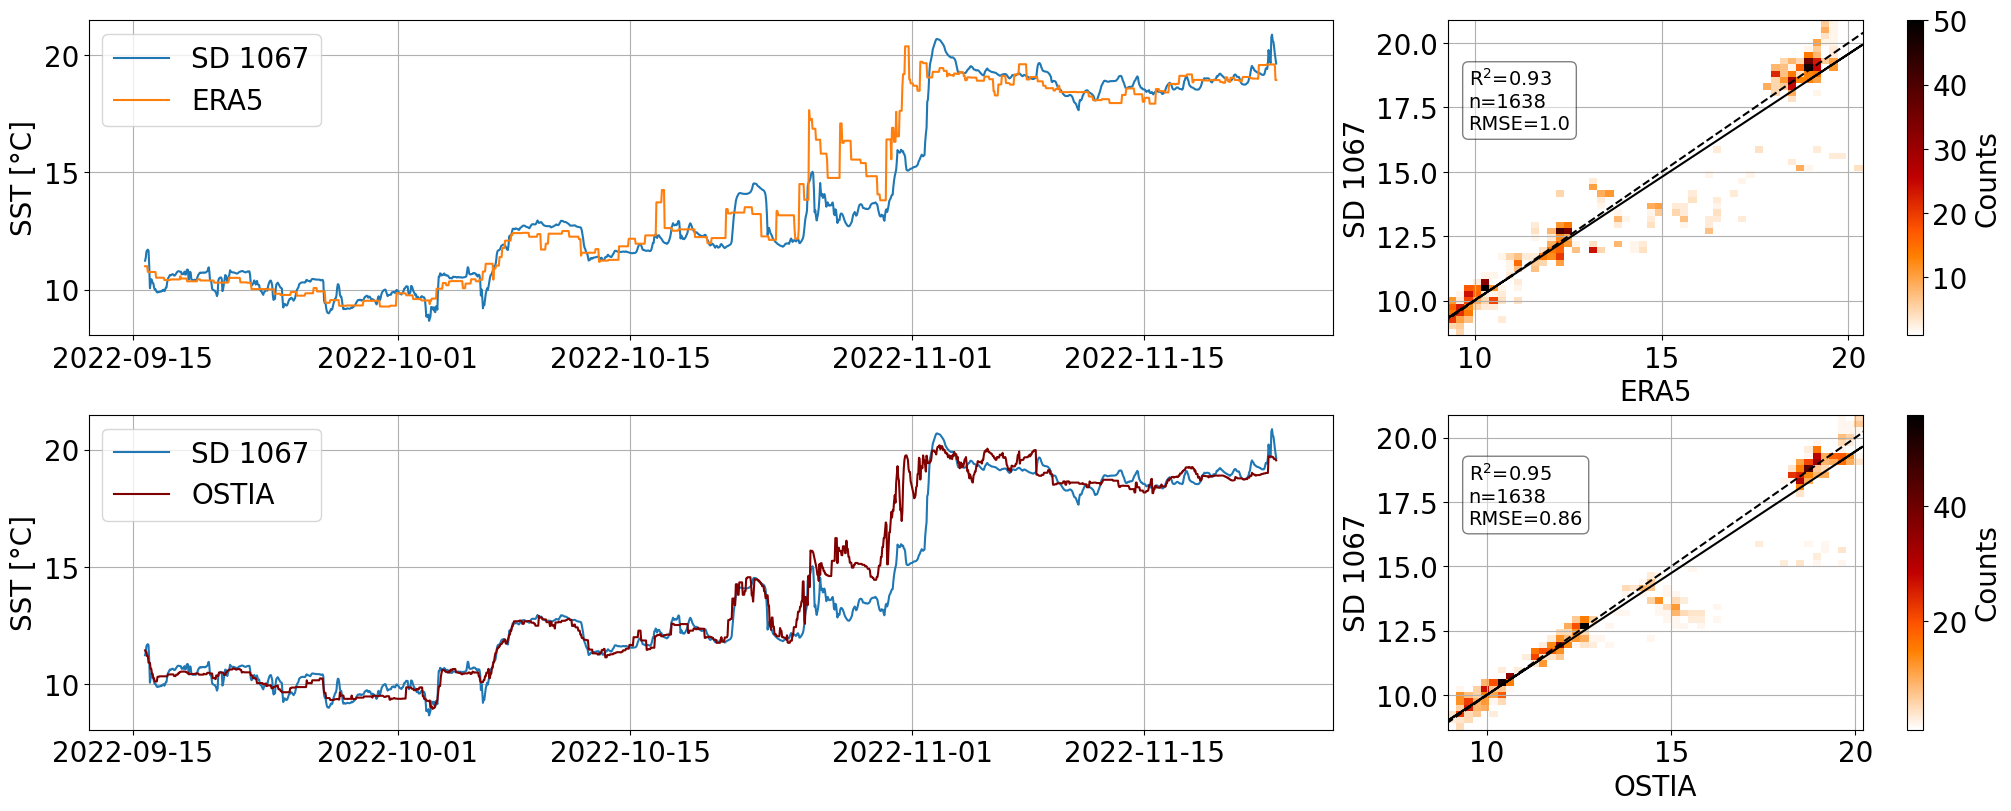

In [7]:
fig, ax = plt.subplot_mosaic([['a','a','a' ,'b'], ['c','c','c', 'd']], figsize=[20,8], layout='constrained')

ax['a'].plot(dsadcpH.time, dsadcpH.sst, label='SD 1067')
ax['a'].plot(dsadcpH.time, coloc3.sst, label='ERA5')
ax['a'].grid()
ax['a'].legend()

ax['c'].plot(dsadcpH.time, dsadcpH.sst, label='SD 1067')
ax['c'].plot(dsadcpH.time, colocOSTIA, c='maroon', label='OSTIA')
ax['c'].grid()
ax['c'].legend()



scat=ax['b'].hist2d(coloc3.sst, dsadcpH['sst'].sel(time=np.isfinite(dsadcpH['sst'])), bins=50,cmin=1, cmax=60, cmap='gist_heat_r')
fig.colorbar(scat[3], ax=ax['b'], label='Counts')

scat=ax['d'].hist2d(colocOSTIA, dsadcpH['sst'].sel(time=np.isfinite(dsadcpH['sst'])), bins=50,cmin=1, cmax=60, cmap='gist_heat_r')
fig.colorbar(scat[3], ax=ax['d'], label='Counts')

#Create linear fit line and plot
y=dsadcpH['sst'].sel(time=np.isfinite(dsadcpH['sst']))
x=coloc3.sst

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
ax['b'].plot(x, m*x+b, color='k', label='Linear fit')

#Create stats and statbox
RMSE = math.sqrt(mean_squared_error(x, y))


#r2=scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).rvalue**2
n = len(coloc3.sst)
p= scipy.stats.linregress(x,y).pvalue
r2=scipy.stats.linregress(x,y).rvalue**2

textstr= 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 

ax['b'].plot(np.arange(y.min(), y.max(), 1), np.arange(y.min(), y.max(), 1) , linestyle='--', color='k', label=('1:1'))


#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#ax[corr[i]].set_aspect('equal', adjustable="datalim")

# place a text box in upper left in axes coords
ax['b'].annotate(textstr, xy=(0.05, 0.85), xycoords='axes fraction', bbox=props, va='top',fontsize=14)






#Create linear fit line and plot
y=dsadcpH['sst'].sel(time=np.isfinite(dsadcpH['sst']))
x=colocOSTIA

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
ax['d'].plot(x, m*x+b, color='k', label='Linear fit')

#Create stats and statbox
RMSE = math.sqrt(mean_squared_error(x, y))


#r2=scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).rvalue**2
n = len(x)
p= scipy.stats.linregress(x,y).pvalue
r2=scipy.stats.linregress(x,y).rvalue**2

textstr= 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 

ax['d'].plot(np.arange(y.min(), y.max(), 1), np.arange(y.min(), y.max(), 1) , linestyle='--', color='k', label=('1:1'))


#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#ax[corr[i]].set_aspect('equal', adjustable="datalim")

# place a text box in upper left in axes coords
ax['d'].annotate(textstr, xy=(0.05, 0.85), xycoords='axes fraction', bbox=props, va='top',fontsize=14)


ax['d'].grid()
ax['b'].grid()

ax['d'].set_ylabel('SD 1067')
ax['b'].set_ylabel('SD 1067')

ax['b'].set_xlabel('ERA5')
ax['d'].set_xlabel('OSTIA')

ax['a'].set_ylabel('SST [°C]')
ax['c'].set_ylabel('SST [°C]')

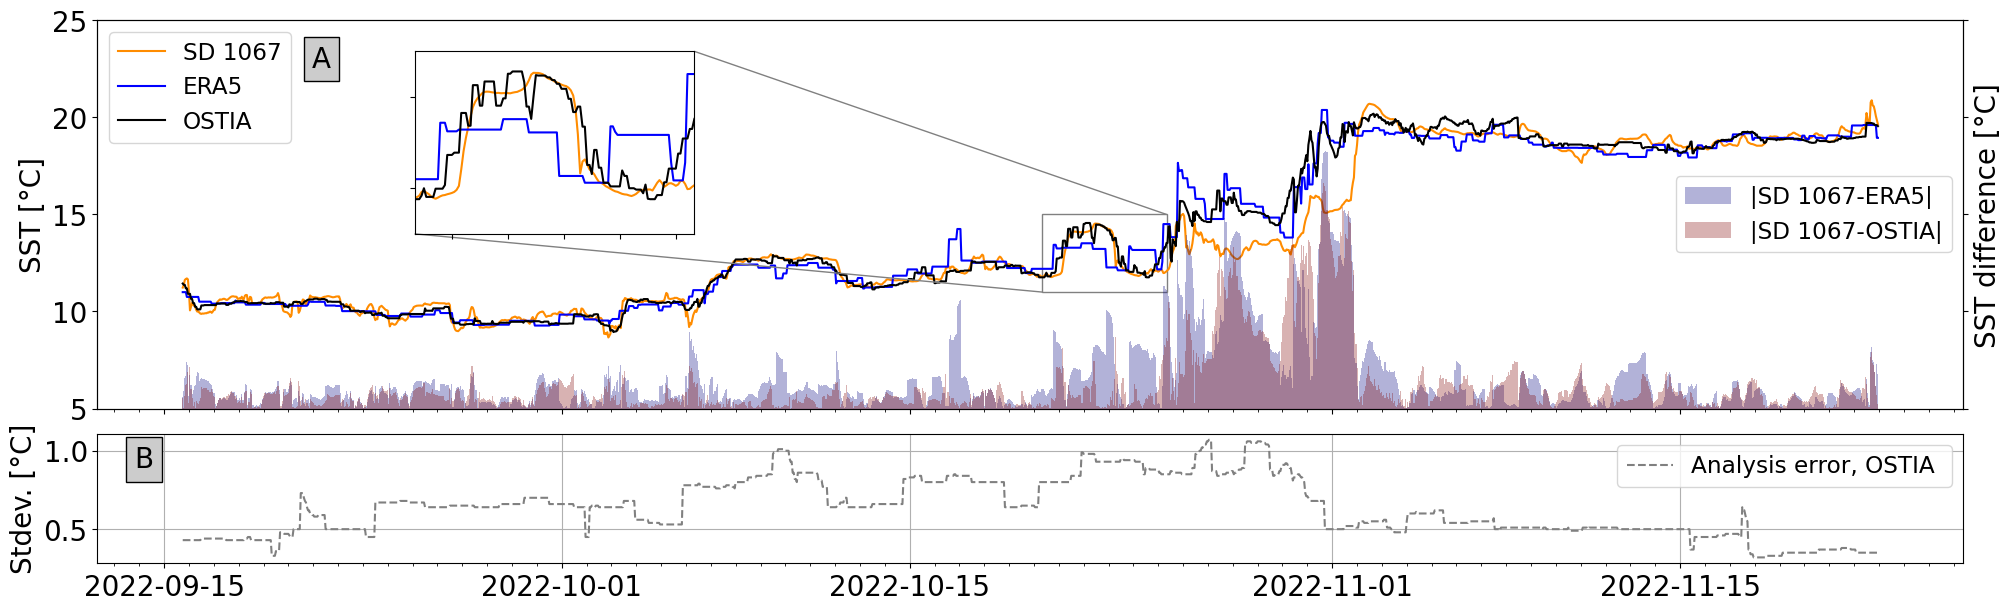

In [8]:
fig, ax = plt.subplot_mosaic([['b','b','b'], ['b','b','b'], ['b','b','b'],['a','a','a']], figsize=[20,6], layout='constrained', sharex=True)




ax['b'].plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD 1067')
ax['b'].plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
ax['b'].plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA')


ax1=ax['b'].twinx()
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-coloc3.sst),alpha=0.3,width=pd.Timedelta(hours=1), label='|SD 1067-ERA5|', color='navy')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA),alpha=0.3,width=pd.Timedelta(hours=1), label='|SD 1067-OSTIA|', color='maroon')
ax1.set_ylabel('SST difference [°C]')

ax['a'].plot(dsadcpH.time, colocOSTIA_analysis_error,color='grey',linestyle='--', label='Analysis error, OSTIA ')
ax['a'].legend(fontsize='small')
ax['a'].grid()
ax['a'].set_ylabel('Stdev. [°C]')

ax['b'].xaxis.set_minor_locator(mdates.DayLocator())
#ax.grid()
ax['b'].legend(fontsize='small')
ax['b'].set_ylim(5,25)

ax1.legend(loc='center right', fontsize='small')
ax1.set_ylim(0,8)

#sns.barplot(x=dsadcpH.time, y=np.abs(dsadcpH.sst-coloc3.sst),ax=ax1 )
#sns.barplot(x=dsadcpH.time, y=np.abs(dsadcpH.sst-colocOSTIA),ax=ax1 )

#ax['b'].set_xlabel('Date')
ax['b'].set_ylabel('SST [°C]')

i=830 # choose index for start time on zoom-window

#Zoom window
x1, x2, y1, y2 = dsadcpH.time[i], dsadcpH.time[i+120], 11, 15 # subregion of the original image

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax['b'], 2, loc='upper center')#, axes_kwargs=dict(anchor=[dsadcpH.time[50].values, 15]))#, loc='upper left') # zoom = 2

x_pos=0.17
y_pos=0.45

width=0.15
height=0.47

axins= ax['b'].inset_axes([x_pos, y_pos, width, height], xticklabels=[], yticklabels=[]) 

axins.plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD 1067')
axins.plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
axins.plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA')


axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax['b'], axins, loc1=3, loc2=1, fc="none", ec="0.5")


bbox = dict(boxstyle="square", fc="0.8")


ax['a'].annotate('B', xy=(0.02, 0.74), xycoords='axes fraction', bbox=bbox)
ax['b'].annotate('A', xy=(0.115, 0.88), xycoords='axes fraction', bbox=bbox)

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/sst.png')
plt.draw()
plt.show()




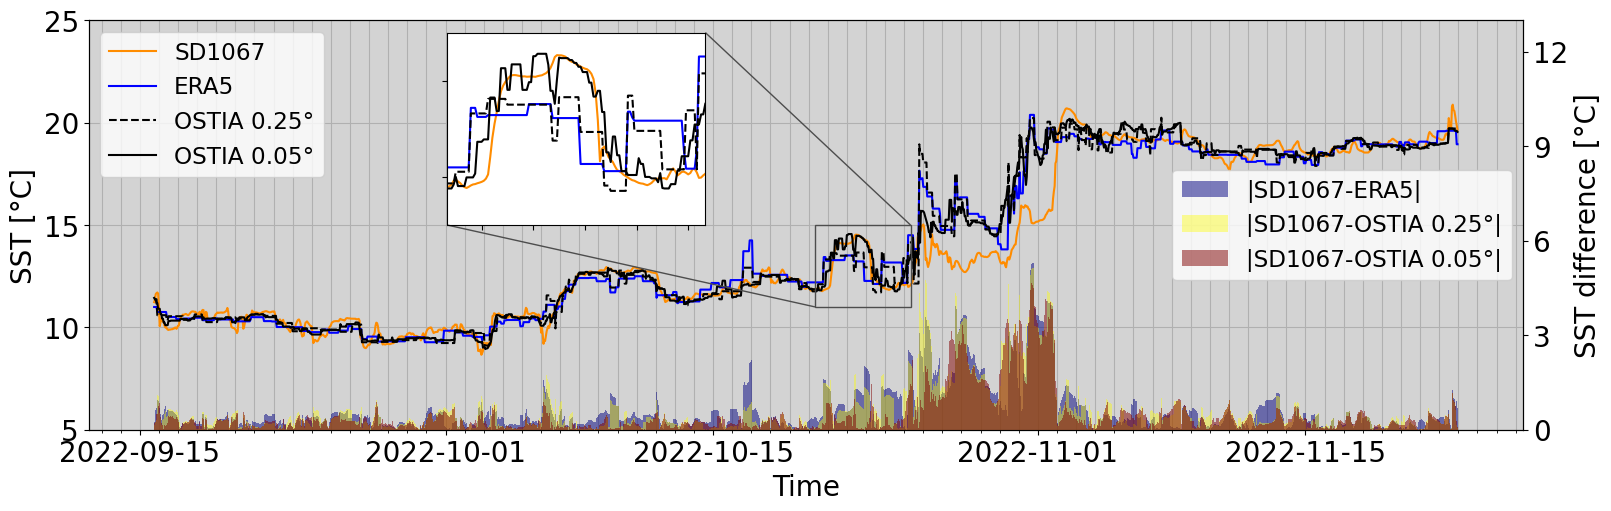

In [11]:
fig, ax = plt.subplot_mosaic([['b','b','b'], ['b','b','b'], ['b','b','b']], figsize=[16,5], layout='constrained')#, sharex=True)




ax['b'].plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD1067')
ax['b'].plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
ax['b'].plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA 0.25°', linestyle='--')
ax['b'].plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA 0.05°')


bbox = dict(boxstyle="square", facecolor='w')#, fc="0.8", facecolor='w')


#ax['a'].annotate('B', xy=(0.02, 0.74), xycoords='axes fraction', bbox=bbox)
#ax['b'].annotate('A', xy=(0.142, 0.88), xycoords='axes fraction', bbox=bbox)
ax['b'].set_facecolor('#D3D3D3')
ax['b'].xaxis.set_minor_locator(mdates.DayLocator())
#ax.grid()
ax['b'].legend(fontsize='small')
ax['b'].set_ylim(5,25)

#ax['b'].set_xlabel('Date')
ax['b'].set_ylabel('SST [°C]')

#sst difference axis
ax1=ax['b'].twinx()
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-coloc3.sst),alpha=0.5,width=pd.Timedelta(hours=1), label='|SD1067-ERA5|', color='navy')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA_regrid),alpha=0.4,width=pd.Timedelta(hours=1), label='|SD1067-OSTIA 0.25°|', color='yellow')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA),alpha=0.5,width=pd.Timedelta(hours=1), label='|SD1067-OSTIA 0.05°|', color='maroon')

ax1.set_ylabel('SST difference [°C]')

ax1.legend(loc='center right', fontsize='small')
ax1.set_ylim(0,13)
ax1.yaxis.set_ticks(ticks=np.arange(0, 13, 3), labels=[0,3,6,9,12])
ax['b'].set_xlabel('Time')

i=830 # choose index for start time on zoom-window

#Zoom window
x1, x2, y1, y2 = dsadcpH.time[i], dsadcpH.time[i+120], 11, 15 # subregion of the original image

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax['b'], 2, loc='upper center')#, axes_kwargs=dict(anchor=[dsadcpH.time[50].values, 15]))#, loc='upper left') # zoom = 2

x_pos=0.25
y_pos=0.5

width=0.18
height=0.47

axins= ax['b'].inset_axes([x_pos, y_pos, width, height], xticklabels=[], yticklabels=[]) 

axins.plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD 1067')
axins.plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
axins.plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA 0.05°')
axins.plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA 0.25°', linestyle='--')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.xticks(visible=False)
#axins.yticks(visible=False)
mark_inset(ax['b'], axins, loc1=3, loc2=1, fc="none", ec="0.3", zorder=2)

ax['b'].grid(which='both', zorder=1)


plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/sst.png')

plt.draw()
plt.show()



## Regridded OSTIA SST figure

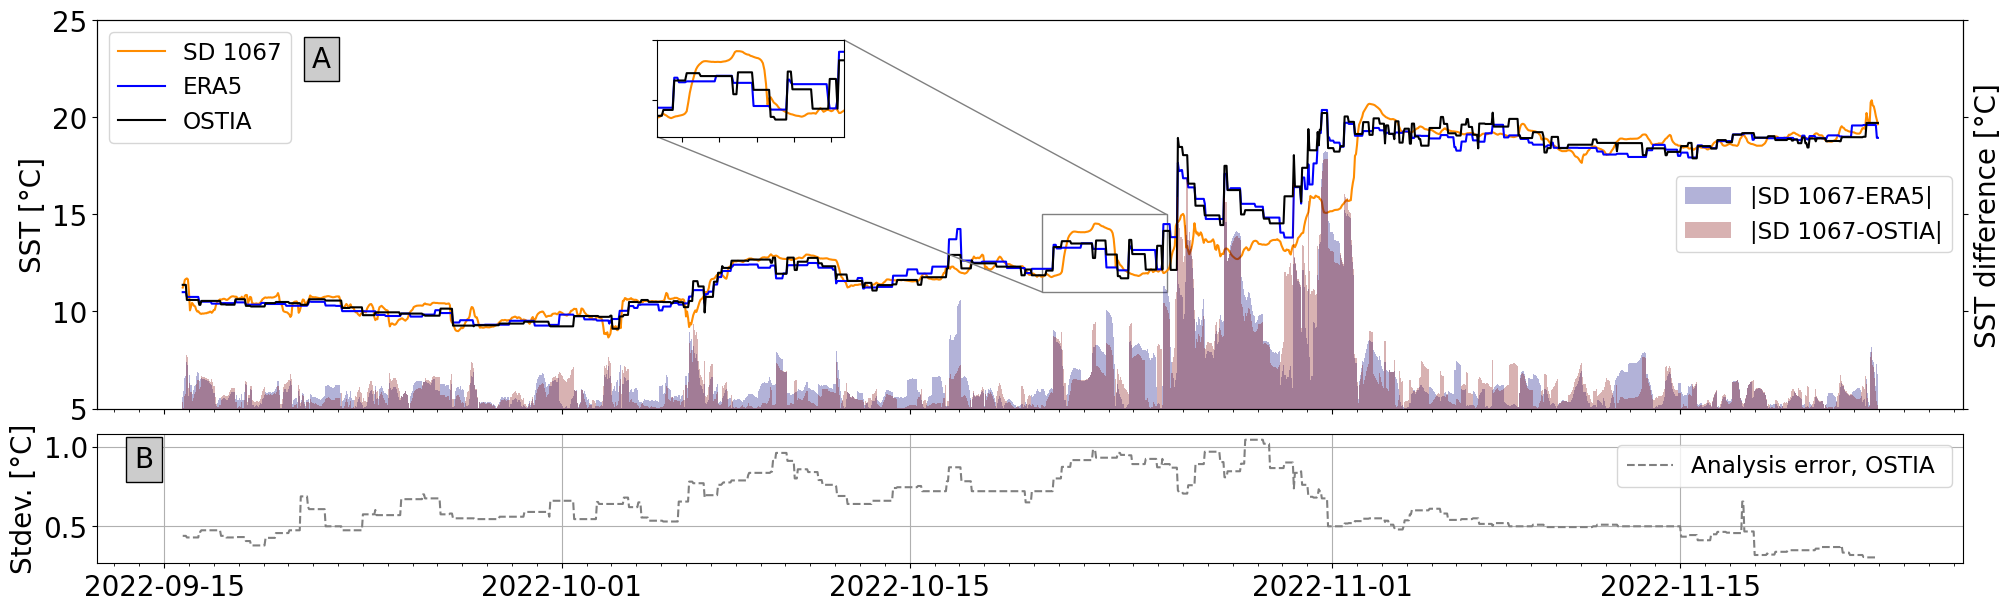

In [19]:
fig, ax = plt.subplot_mosaic([['b','b','b'], ['b','b','b'], ['b','b','b'],['a','a','a']], figsize=[20,6], layout='constrained', sharex=True)




ax['b'].plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD 1067')
ax['b'].plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
ax['b'].plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA')


ax1=ax['b'].twinx()
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-coloc3.sst),alpha=0.3,width=pd.Timedelta(hours=1), label='|SD 1067-ERA5|', color='navy')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA_regrid),alpha=0.3,width=pd.Timedelta(hours=1), label='|SD 1067-OSTIA|', color='maroon')
ax1.set_ylabel('SST difference [°C]')

ax['a'].plot(dsadcpH.time, colocOSTIA_regrid_analysis_error,color='grey',linestyle='--', label='Analysis error, OSTIA ')
ax['a'].legend(fontsize='small')
ax['a'].grid()
ax['a'].set_ylabel('Stdev. [°C]')

ax['b'].xaxis.set_minor_locator(mdates.DayLocator())
#ax.grid()
ax['b'].legend(fontsize='small')
ax['b'].set_ylim(5,25)

ax1.legend(loc='center right', fontsize='small')
ax1.set_ylim(0,8)

#sns.barplot(x=dsadcpH.time, y=np.abs(dsadcpH.sst-coloc3.sst),ax=ax1 )
#sns.barplot(x=dsadcpH.time, y=np.abs(dsadcpH.sst-colocOSTIA),ax=ax1 )
 
#ax['b'].set_xlabel('Date')
ax['b'].set_ylabel('SST [°C]')

i=830 # choose index for start time on zoom-window

#Zoom window
x1, x2, y1, y2 = dsadcpH.time[i], dsadcpH.time[i+120], 11, 15 # subregion of the original image

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax['b'], 2, loc='upper center')#, axes_kwargs=dict(anchor=[dsadcpH.time[50].values, 15]))#, loc='upper left') # zoom = 2

axins= ax['b'].inset_axes([0.3, 0.7, 0.1, 0.25], xticklabels=[], yticklabels=[])

axins.plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD 1067')
axins.plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
axins.plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA')


axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax['b'], axins, loc1=3, loc2=1, fc="none", ec="0.5")


bbox = dict(boxstyle="square", fc="0.8")


ax['a'].annotate('B', xy=(0.02, 0.74), xycoords='axes fraction', bbox=bbox)
ax['b'].annotate('A', xy=(0.115, 0.88), xycoords='axes fraction', bbox=bbox)

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/sst_ostia_regrid.png')
plt.draw()
plt.show()



In [ ]:
 scipy.stats.linregress(colocOSTIA, dsadcpH['sst'].sel(time=np.isfinite(dsadcpH['sst'])))

Last constant wind SD data needs to be removed, why has it appeared? DONE masked out w help of UWND finite-values

In [ ]:
hum1=dsadcpH.rh.values

spd= coloc3.abs_rel.values#relative windpeed
SST= dsadcpH.sst.values
T= dsadcpH.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
P= dsadcpH.P_SEA.values #air pressure in hPA
SST_fl ='bulk' #string, 'bulk' or 'skin' for input
meth= 'C35' #string, choose method of calcultion
lat= dsadcpH.latitude.values #latitude
hin=([10, 2.3, 2.3])  #sensor heights in m, 3x1 same order as output 
hout=10 #output height, default is 10m
Rl=dsadcpH.dwlw.values#longwave dwn radiation
Rs= dsadcpH.dwsw.values # shortwave dwn radiation
cskin= 1 #0 cool skin adj off
skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
wl=1 #warm layer off 0 (default)
gust= None# [x,beta,zi,ustbj] #Check documentation
qmeth= 'Buck2' #string, saturation evaporation method
tol= None #float, tolerance limits for fluxes and heights, check documentation
maxiter= 30 #number fo iterations
out= 0 #int, set 0 to set points thathave not converged
out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
L=None #str, M-O definition option. 'tsrv' is default

ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                   hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                   gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                   out_var=out_var, L=L)


ASFC['time']=dsadcpH.time.values
ASFC['latitude']=dsadcpH.latitude.values
ASFC['longitude']=dsadcpH.longitude.values
ASFC=ASFC.to_xarray().swap_dims({'index':'time'}).drop('index').set_coords(['longitude', 'latitude'])
ASFC['skin']=(SST-(ASFC.dter-273.15)+(ASFC.dtwl-273.15))
ASFC['deltaT']=(ASFC.tref-273.15)-ASFC.skin
ASFC['deltaq']=ASFC.qref-ASFC.qsea

In [ ]:
ASFC=ASFC.rename({'Rs':'dwsw'})
ASFC=ASFC.rename({'Rl':'dwlw'})
ERA5['sensible']=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5flux.nc').msshf
ERA5['latent']=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5flux.nc').mslhf

In [ ]:
coloc4=pd.read_table(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc4.csv', delimiter=',').to_xarray()
coloc4['time']=('index', dsadcpH.time.values)
coloc4=coloc4.swap_dims({'index':'time'})

In [ ]:
variables=['dwsw', 'dwlw', 'sensible', 'latent' ]
coloc4=pd.DataFrame(columns=variables)
#msk=np.isfinite(dsadcpH.P_SEA)

for i in np.arange(len(variables)):
    #coloc3[variables[i]]=colocate_era5_sd(dsadcpH.sel(time=msk), ERA5, variables[i])
    coloc4[variables[i]]=colocate_era5_sd(ASFC, ERA5, variables[i])
    

coloc4.to_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc4.csv')

In [ ]:
coloc4=pd.read_table(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc4.csv', delimiter=',').to_xarray()
coloc4['time']=('index', dsadcpH.time.values)
coloc4=coloc4.swap_dims({'index':'time'})

In [ ]:
night=0 #define limit for nighttime values
#msk=np.isfinite(ASFC['dwsw'])
coloc5=coloc4.sel(time=np.isfinite(ASFC['dwsw']))
ASFC2=ASFC.sel(time=np.isfinite(ASFC['dwsw']))

dwswE5day=coloc5.sel(time=((coloc5.dwsw>night)))
dwswday=ASFC2['dwsw'].sel(time=((coloc5.dwsw>night)))

In [ ]:
variables=['dwsw', 'dwlw', 'sensible', 'latent' ]
coloc4msk=[] 
for i in np.arange(len(variables)):
    msk=np.isfinite(ASFC[variables[i]])
    coloc4msk.append(colocate_era5_sd(ASFC.sel(time=msk), ERA5, variables[i]))

In [ ]:
fig, ax = plt.subplot_mosaic([['a','a','a' ,'b'], ['c','c','c', 'd'], ['e','e','e' ,'f'], ['g','g','g', 'h']], figsize=[20,17], layout='constrained')
tims=['c','e', 'g']
corr=['d', 'f', 'h']
var=['dwlw', 'sensible', 'latent']
colocno=[1, 2, 3] #sst, t2m, wind_corr10, rh
textstr=[]
lin=[]

for i in np.arange(len(var)):
    ax[tims[i]].plot(ASFC.time, ASFC[var[i]], label='ASFC')
    ax[tims[i]].plot(ASFC.time, coloc4[var[i]], label='ERA5')
    
    scat=ax[corr[i]].hist2d(coloc4msk[colocno[i]], ASFC[var[i]].sel(time=np.isfinite(ASFC[var[i]])), bins=50,cmin=1, cmax=60, cmap='gist_heat_r')
    fig.colorbar(scat[3], ax=ax[corr[i]], label='Counts')
    
    
    #Create linear fit line and plot
    y=ASFC[var[i]].sel(time=np.isfinite(ASFC[var[i]]))
    x=coloc4msk[colocno[i]]
 
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    ax[corr[i]].plot(x, m*x+b, color='k', label='Linear fit')
    
    #Create stats and statbox
    y_actual = coloc4msk[colocno[i]] 
    y_predicted =ASFC[var[i]].sel(time=np.isfinite(ASFC[var[i]]))
    RMSE = math.sqrt(mean_squared_error(y_actual, y_predicted))
    
    
    r2=scipy.stats.linregress(coloc4msk[colocno[i]], ASFC[var[i]].sel(time=np.isfinite(ASFC[var[i]]))).rvalue**2
    n = len(coloc4msk[colocno[i]])
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr.append( 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) )
                              
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#    ax[corr[i]].set_aspect('equal', adjustable="datalim")
    
    # place a text box in upper left in axes coords
    ax[corr[i]].annotate(textstr[i], xy=(0.05, 0.85), xycoords='axes fraction', bbox=props, va='top',fontsize=14)
   
    
    ax[corr[i]].set_xlabel('ERA5')
    ax[corr[i]].set_ylabel('SD 1067 (ASFC)')
    ax[corr[i]].plot(np.arange(ASFC[var[i]].min(), ASFC[var[i]].max(), 1), np.arange(ASFC[var[i]].min(), ASFC[var[i]].max(), 1) , linestyle='--', color='k', label=('1:1'))
      #ad grid, legend, 1:1 line
#    ax[tims[i]].legend()#loc='upper left')
    ax[tims[i]].xaxis.set_minor_locator(mdates.DayLocator())
    ax[tims[i]].grid()
    ax[corr[i]].grid()
    
    ax[corr[i]].legend(loc='lower right', fontsize=15 )

    
ax['a'].set_ylabel('DWSW [W/m$^2$]')   
ax['c'].set_ylabel('DWLW [W/m$^2$]')   
ax['e'].set_ylabel('Q$_S$ [W/m$^2$]')      
ax['g'].set_ylabel('Q$_L$ [W/m$^2$]') 


    #coloc3: PSEA, WIND_CORR10, u10, v10, dwlw, dwsw, sst, t2m, rh
    
   
#for dwsw daytime


ax['a'].plot(ASFC.time, ASFC.dwsw, label='SD 1067/ASFC')
ax['a'].plot(ASFC.time, coloc4.dwsw, label='ERA5')


scat=ax['b'].hist2d(dwswE5day.dwsw.values, dwswday, bins=50,cmin=1, cmax=40, cmap='gist_heat_r')
fig.colorbar(scat[3], ax=ax['b'], label='Counts')


#Create linear fit line and plot
y=dwswday.values
x=dwswE5day.dwsw.values

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
ax['b'].plot(x, m*x+b, color='k', label='Linear fit')

#Create stats and statbox
y_actual = x
y_predicted = y
RMSE = math.sqrt(mean_squared_error(y_actual, y_predicted))


r2=scipy.stats.linregress(dwswE5day.dwsw.values, dwswday).rvalue**2
n = len(dwswE5day.dwsw.values)


textstr=( 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) )

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#    ax[corr[i]].set_aspect('equal', adjustable="datalim")

# place a text box in upper left in axes coords
ax['b'].annotate(textstr, xy=(0.05, 0.85), xycoords='axes fraction', bbox=props, va='top',fontsize=14)
ax['b'].plot(np.arange(ASFC.dwsw.min(), ASFC.dwsw.max(), 1), np.arange(ASFC.dwsw.min(), ASFC.dwsw.max(), 1) , linestyle='--', color='k', label=('1:1'))
#ad grid, legend, 1:1 line
ax['a'].legend(fontsize='small')#loc='upper left')
ax['a'].xaxis.set_minor_locator(mdates.DayLocator())
ax['a'].grid()
ax['b'].grid()

ax['b'].legend(loc='lower right', fontsize=15 )   
ax['b'].set_xlabel('ERA5')
ax['b'].set_ylabel('SD 1067')
ax['d'].set_ylabel('SD 1067')

#ax['a'].sharex(ax['c'])
    
_ = [ax[i].sharex(ax['a']) for i in 'ceg']    
_ = [ax[i].tick_params(labelbottom=False) for i in "ace"]
#_ = [ax[i].sharey(ax['g']) for i in 'e'] 
#_ = [ax[i].tick_params(labelleft=False) for i in "BD"]
    
    
plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/figures/sochicflux.png')

## Transect fig. with OSTIA contourf plot


Used for introduction in the report. Added some arrows for different aghulas features

In [5]:
gebco=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/gebcoCT.nc') #too small for new borders
dsD=ds.reset_coords().resample(time='1D').mean().set_coords(['latitude','longitude']) #resample to daily res. for mapping

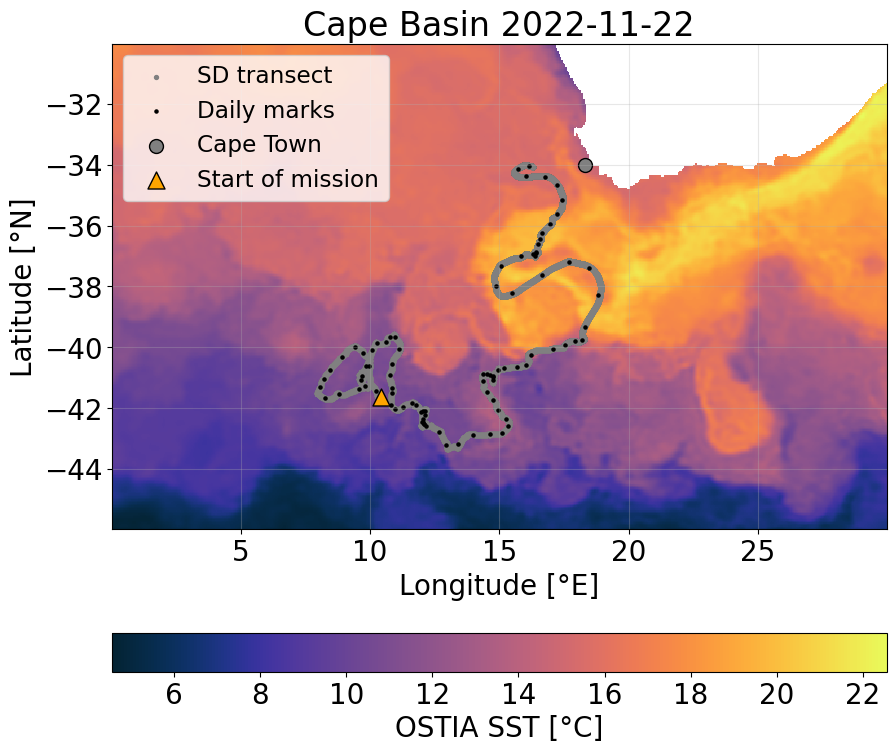

In [6]:
i=27

plt.rcParams["figure.figsize"] = (10,9)

cbar=plt.pcolormesh(ostia.longitude, ostia.latitude, ostia.sst.isel(time=i)-273.15, cmap=cmo.cm.thermal)
plt.colorbar(cbar, label='OSTIA SST [°C]', orientation='horizontal')

plt.scatter(ds.longitude, ds.latitude, s=8, label='SD transect', c='grey')#, alpha=0.2)
plt.scatter(dsD.longitude, dsD.latitude, c='k', s=5, label='Daily marks')

#plt.contour(gebco.lon, gebco.lat, gebco.elevation,levels=[0], colors='k')

plt.xlabel('Longitude [°E]')
plt.ylabel('Latitude [°N]')

plt.scatter(18.3, -34, c='grey', marker='o', s=100, edgecolor='k', label='Cape Town')

plt.scatter(ds.longitude.isel(time=0), ds.latitude.isel(time=0), c='orange', marker='^', s=150, edgecolor='k', label='Start of mission')
#plt.scatter(ds.longitude.sel(time=ds.time.max()), ds.latitude.sel(time=ds.time.max()), c='r', marker='*', s=300, edgecolor='k')#, label='End of mission')

plt.xlim(ostia.longitude.min(), ostia.longitude.max())
plt.ylim(ostia.latitude.min(), ostia.latitude.max())
plt.legend(fontsize='small', loc='upper left')

plt.title('Cape Basin 2022-11-22')

plt.grid(alpha=0.3)
#plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/area.png')

In [7]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.ticker as mticker

def gridlines(ax,lon_tick,lat_tick, ToF_bottom, ToF_left):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      x_inline=False, y_inline=False,
                      linewidth=0.75, alpha=0.2, linestyle='--',color='grey',
                      ylocs = mpl.ticker.MultipleLocator(base=lat_tick),xlocs = mpl.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlocator = mticker.FixedLocator([0, 10, 20, 30])
    
    gl.xpadding=10
    gl.ypadding=10
    gl.bottom_labels = ToF_bottom
    gl.left_labels = ToF_left


In [8]:
ERA5big.latitude.min()

<xarray.DataArray 'latitude' ()>
array(-46., dtype=float32)

In [9]:
SSH=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SSH.nc')

In [10]:
SSH

<xarray.Dataset>
Dimensions:         (time: 91, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time            (time) datetime64[ns] 2022-09-01 2022-09-02 ... 2022-11-30
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             (time) int32 ...
    lat_bnds        (time, latitude, nv) float32 ...
    lon_bnds        (time, longitude, nv) float32 ...
    sla             (time, latitude, longitude) float64 ...
    err_sla         (time, latitude, longitude) float64 ...
    ugosa           (time, latitude, longitude) float64 ...
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 ...
    adt             (time, latitude, longitude) float64 ...
    ugos            (time, latitude, longitude) float64 ...
    vgos            (time, latitude, longitude) float64 ...
    tpa_correction  (time) float64 ...
    flag_ice        (time, latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2022-09-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2022-08-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [11]:
SSH.isel(time=82)

<xarray.Dataset>
Dimensions:         (latitude: 720, nv: 2, longitude: 1440)
Coordinates:
    time            datetime64[ns] 2022-11-22
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             int32 ...
    lat_bnds        (latitude, nv) float32 ...
    lon_bnds        (longitude, nv) float32 ...
    sla             (latitude, longitude) float64 ...
    err_sla         (latitude, longitude) float64 ...
    ugosa           (latitude, longitude) float64 ...
    ...              ...
    err_vgosa       (latitude, longitude) float64 ...
    adt             (latitude, longitude) float64 ...
    ugos            (latitude, longitude) float64 ...
    vgos            (latitude, longitude) float64 ...
    tpa_correction  float64 ...
    flag_ice        (latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2022-09-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2022-08-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

(-45.974998474121094, -30.024999618530273)

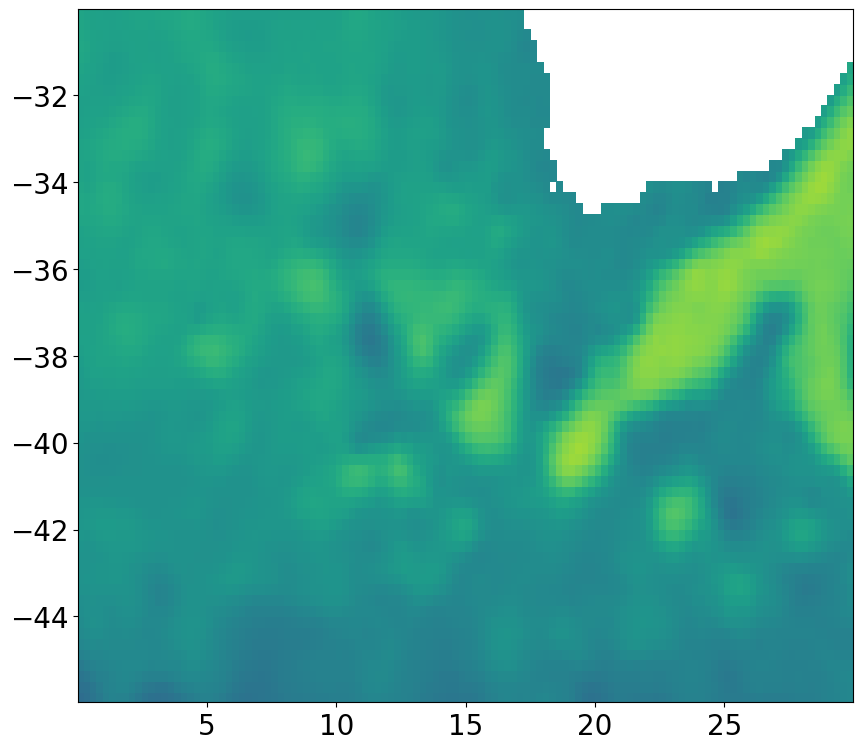

In [13]:
plt.pcolor(SSH.longitude, SSH.latitude, SSH.isel(time=82).adt)

plt.xlim(ostia.longitude.min(), ostia.longitude.max())
plt.ylim(ostia.latitude.min(), ostia.latitude.max())



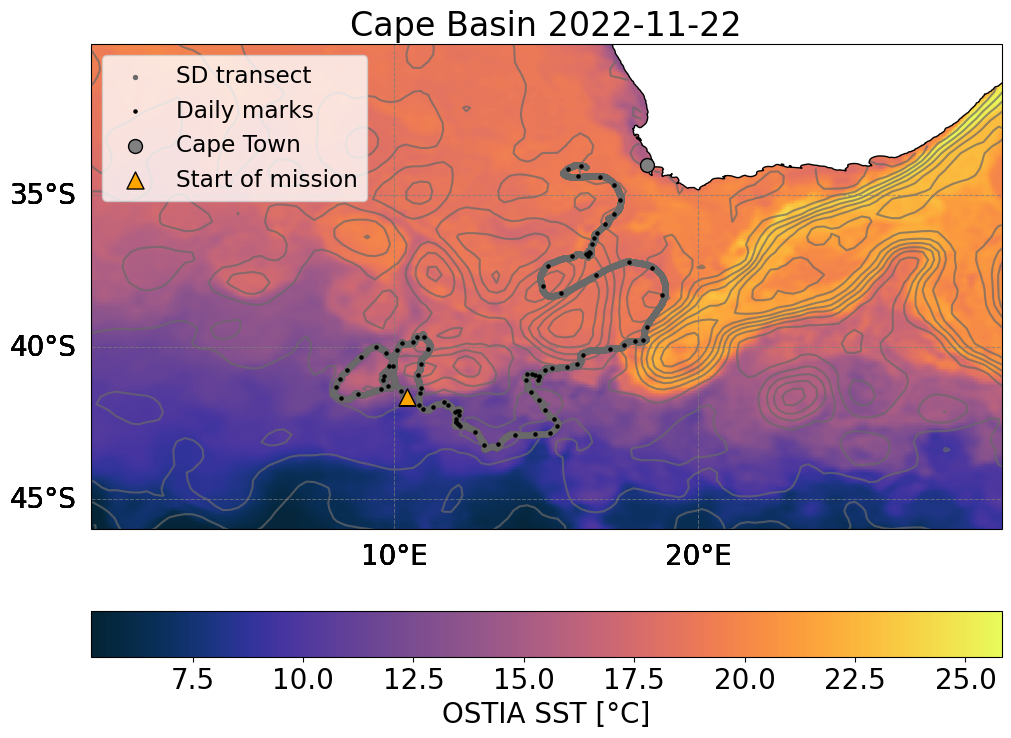

In [15]:
fig, ax=plt.subplots(figsize=[10,9],subplot_kw={'projection':ccrs.PlateCarree()}, constrained_layout=True)

cbar=ax.pcolormesh(ostia.longitude, ostia.latitude, ostia.sst.isel(time=1625)-273.15, cmap=cmo.cm.thermal)
plt.colorbar(cbar,ax=ax, label='OSTIA SST [°C]', orientation='horizontal')

ax.scatter(ds.longitude, ds.latitude, s=8, label='SD transect', c='dimgrey', zorder=4)#, alpha=0.2)
ax.scatter(dsD.longitude, dsD.latitude, c='k', s=5, label='Daily marks', zorder=5)
ax.contour(SSH.longitude, SSH.latitude, SSH.isel(time=82).adt, colors='dimgray', zorder=1, levels=20, alpha=0.7)

#plt.contour(gebco.lon, gebco.lat, gebco.elevation,levels=[0], colors='k')

ax.set_xlabel('Longitude [°E]')
ax.set_ylabel('Latitude [°N]')

ax.scatter(18.3, -34, c='grey', marker='o', s=100, edgecolor='k', label='Cape Town', zorder=4)

ax.scatter(ds.longitude.isel(time=0), ds.latitude.isel(time=0), c='orange', marker='^', s=150, edgecolor='k', label='Start of mission', zorder=4)
#plt.scatter(ds.longitude.sel(time=ds.time.max()), ds.latitude.sel(time=ds.time.max()), c='r', marker='*', s=300, edgecolor='k')#, label='End of mission')

ax.set_xlim(ostia.longitude.min(), ostia.longitude.max())
ax.set_ylim(ostia.latitude.min(), ostia.latitude.max())
ax.legend(fontsize='small', loc='upper left')

ax.set_title('Cape Basin 2022-11-22')

ax.grid(alpha=0.3)

for k,spine in ax.spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax,10,5, True, True)


ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/area.png')

In [48]:
ax.spines.items()

ItemsView(<matplotlib.spines.Spines object at 0x7ff6973c6060>)

In [40]:
SSH

<xarray.Dataset>
Dimensions:    (time: 354, latitude: 61, longitude: 72)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-20
  * latitude   (latitude) float32 -44.88 -44.62 -44.38 ... -30.38 -30.12 -29.88
  * longitude  (longitude) float32 7.125 7.375 7.625 7.875 ... 24.38 24.62 24.88
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
    err_vgosa  (time, latitude, longitude) float64 ...
    err_ugosa  (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    err_sla    (time, latitude, longitude) float64 ...
    flag_ice   (time, latitude, longitude) float64 ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-12-17T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-12-16T12:00:00Z
    title:                           NRT merged all satellites Global Ocean G...
    History:                         Translated to CF-1.0 Conventions by Netc...